# Notebook for analysing all VR trials in one experiment folder

## (assumes use of FlyOver version 9.2 or higher)


In [428]:
%%html
<script>
    var code_show=true; //true -> hide code at first

    function code_toggle() {
        $('div.prompt').hide(); // always hide prompt

        if (code_show){
            $('div.input').hide();
        } else {
            $('div.input').show();
        }
        code_show = !code_show
    }
    $( document ).ready(code_toggle);
</script>

<a href="javascript:code_toggle()">[Toggle Code]</a>

In [1]:
import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk
from os.path import isfile, sep
from sys import path, exit
from glob import glob

from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

path.insert(1, '/Users/hannah/Dropbox/code/flyVR/flyVRAnalysis/')
from flyVR_oneTrialBasicAnalysis import singleVRTrialAnalysis

path.insert(1, '/Users/hannah/Dropbox/code/plottingUtilities/')
from plottingUtilities import makeNestedPlotDirectory, myAxisTheme
from objectInteractionPlots import residencyWithHistograms_splitOnWalking, curvatureVsHeading_DistanceBoxplot,\
plotResidencyInMiniarena, radDistAngleCombiPlot
from flyTracePlots import plotPosInRange, plotFlyVRtimeStp, plotPolarTrace

path.insert(1, '/Users/hannah/Dropbox/code/trajectoryAnalysis/')
from trajectoryDerivedParams import relationToObject, cartesian2polar, polarCurvature, fitGMMtoSingleTrial
from plotsWithDataframe import plotVeloHeadingDistribution_flyVR_df, oneDimResidency_df

plotPolarTrace

%matplotlib inline 

# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')


 Analysing the following folders:

['WTBm01', 'WTBm02', 'WTBm03', 'WTBm04', 'WTBm05', 'WTBm06', 'WTBm07', 'WTBm08', 'WTBm09', 'WTBm10', 'WTBm11', 'WTBm12', 'WTBm13', 'WTBm14', 'WTBm15', 'WTBm16', 'WTBm17', 'WTBm18', 'WTBm19', 'WTBm20']
Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)
n


In [500]:
#expDirs = expDirs[:20]
from operator import itemgetter
my_indices = [3,9,18] #[1,2,3,4,5,9,10,14,15,17,18]
expDirs = itemgetter(*my_indices)(expDirs)

### Compose mutli-fly data into dataframe

In [501]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

In [502]:
expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [503]:
keylist = ['curvature','gamma','gammaFull','headingAngle','objectDistance','rotVelo','time',
           'transVelo','xPos','xPosInMiniarena','yPos','yPosInMiniarena']

keylistLong = ['flyID','trial','trialtype','moving','walking'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

In [504]:
nTrialsVI = 0
nTrialsIN = 0
 
vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:

        flyID = fileToAnalyse.split('_')[0]
        trial = FODataFiles.index(fileToAnalyse) + 1
        
        if rerunbasicanalysis == 'y':
            returnVal = singleVRTrialAnalysis(expDir + fileToAnalyse)
            print('Ran analysis, now loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
        else:
            print('Loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]

        # Split into visible object trials and invisible object trials
        if 'Invisible' in fileToAnalyse or 'invisible' in fileToAnalyse:
            trialtype = 'invisible'
            nTrialsIN += 1
        else:
            trialtype = 'visible'
            nTrialsVI += 1
        
        # test if moving
        vTrans = np.copy(FODatLoad['transVelo'])
        moving = vTrans >= vTransTH
        
        # test if in walking bout
        walkingboutTH = fitGMMtoSingleTrial(vTrans,False)
        vTrans_filt = np.copy(vTrans)
        vTrans_filt[vTrans_filt>30.0] = 0
        vTrans_filt = gaussian_filter(vTrans_filt, sigma=3)

        walking = (vTrans_filt>walkingboutTH).astype('bool')

        # add to data frame
        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'moving', moving)
        FODatLoad_df.insert(4, 'walking', walking)
        
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)
        
        # TODO: Add selection criteria, e.g. to only include trials from flies that were 
        # walking >40% of time and did not have a strong turn bias.
        


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTB/males/rawData/WTBm04/

 Analysing the following log files:

['WTBm04_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_5d_out_151123202627.txt', 'WTBm04_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_5d_out_151123204202.txt', 'WTBm04_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_5d_out_151123205248.txt', 'WTBm04_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_5d_out_151123201413.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)




 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTB/males/rawData/WTBm10/

 Analysing the following log files:

['WTBm10_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151206213032.txt', 'WTBm10_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151206214123.txt', 'WTBm10_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151206215129.txt', 'WTBm10_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_6d_out_151206220407.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)




 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/FlyOver093/WTB/males/rawData/WTBm19/

 Analysing the following log files:

['WTBm19_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151210215338.txt', 'WTBm19_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151210220352.txt', 'WTBm19_FlyOver093_singleObjectForest_1cm4cmCone_12cmHex_large_6d_out_151210221410.txt', 'WTBm19_FlyOver093_singleObjectForest_1cm4cmInvisibleCone_12cmHex_large_6d_out_151210222557.txt']
Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)



Loading saved *.npy file.
Loading saved *.npy file.

/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)
/Users/hannah/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function eval is deprecated; GMM.eval was renamed to GMM.score_samples in 0.14 and will be removed in 0.16.
  warnings.warn(msg, category=DeprecationWarning)


In [505]:
FOAllFlies_df =FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')

FOAllFlies_df 

,flyID,trial,trialtype,moving,walking,curvature,gamma,gammaFull,headingAngle,objectDistance,rotVelo,time,transVelo,xPos,xPosInMiniarena,yPos,yPosInMiniarena
0,WTBm04,1,visible,1,1,NaN,NaN,NaN,-0.000004,NaN,0.591670,0.000000,17.238255,60.652700,NaN,35.024900,NaN
1,WTBm04,1,visible,1,1,NaN,NaN,NaN,0.029582,NaN,0.354936,0.050005,12.991946,61.511910,NaN,35.094100,NaN
2,WTBm04,1,visible,1,1,NaN,NaN,NaN,0.047331,NaN,0.118319,0.100009,12.998827,62.153700,NaN,35.194900,NaN
3,WTBm04,1,visible,1,1,NaN,NaN,NaN,0.053247,NaN,0.059158,0.150014,11.754140,62.794700,NaN,35.302700,NaN
4,WTBm04,1,visible,1,1,NaN,NaN,NaN,0.056206,NaN,0.414206,0.200018,8.107711,63.336100,NaN,35.531500,NaN
5,WTBm04,1,visible,1,1,NaN,NaN,NaN,0.076918,NaN,1.538193,0.250023,9.312702,63.659500,NaN,35.776000,NaN
6,WTBm04,1,visible,1,1,NaN,NaN,NaN,0.153835,NaN,1.537992,0.300028,17.459789,63.953300,NaN,36.137300,NaN
7,WTBm04,1,visible,1,1,NaN,NaN,NaN,0.230741,NaN,1.183199,0.350032,18.864448,64.710400,NaN,36.572100,NaN
8,WTBm04,1,visible,1,1,NaN,NaN,NaN,0.289907,NaN,0.768982,0.400037,20.572377,65.545700,NaN,37.010400,NaN
9,WTBm04,1,visible,1,1,NaN,NaN,NaN,0.328359,NaN,0.414093,0.450042,20.986848,66.455300,NaN,37.490900,NaN


In [506]:
keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_gam = keylistLong.index('gamma')
keyind_gamful = keylistLong.index('gammaFull')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')
keyind_walk = keylistLong.index('walking')

genotypeSex = fileToAnalyse.split('_')[0][:-2]

flyIDallarray = np.asarray(FOAllFlies_df.iloc[:,keyind_fly:keyind_fly+1]).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

arenaRad = 60

## Summary plot of walking traces

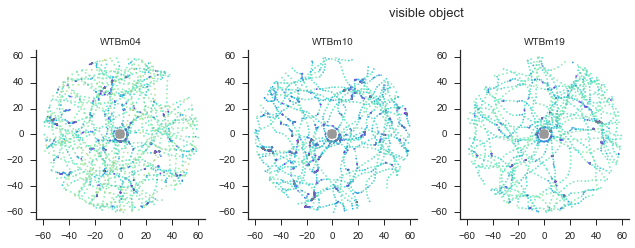

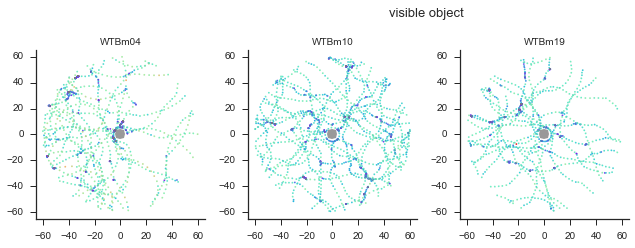

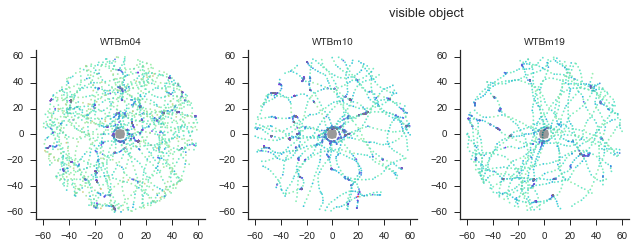

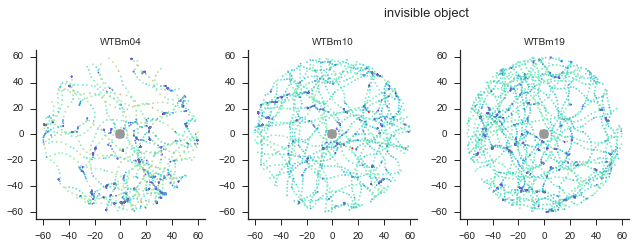

In [507]:
for ttind,trialtype in enumerate(['visible','visible','visible','invisible']):
    multiflyTracePlot = plt.figure(figsize=(12,14))
    figtitle = multiflyTracePlot.suptitle(trialtype + ' object',fontsize=13,y=1.02)
    for fly in range(numFlies):
        multiflyTracePlot_sbplt = multiflyTracePlot.add_subplot(5,4,fly+1)
       
        querystring = '(trialtype=="' + trialtype + '") & (trial==' + str(ttind+1) + ') & (flyID =="' + flyIDs[fly] +  '")'

        perFlyX = FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1].squeeze()
        perFlyY = FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1].squeeze()
        perFlyvT = FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1].squeeze()
        
        selectPts = range(0,len(perFlyX),4)
        #color = scalarMap.to_rgba(timecolor), alpha = 0.1)
        multiflyTracePlot_sbplt.plot(perFlyX[selectPts],perFlyY[selectPts],'.',markersize=3,color='grey',alpha=0.2)
        multiflyTracePlot_sbplt.scatter(perFlyX[selectPts],perFlyY[selectPts],s=3, c=perFlyvT[selectPts], cmap='rainbow',
                                        vmin=-1, vmax=35, edgecolor='none',alpha=0.9)
        multiflyTracePlot_sbplt.plot(0,0,'o',markersize=10, color='black', alpha=0.4)
        
        myAxisTheme(multiflyTracePlot_sbplt)
        multiflyTracePlot_sbplt.set_title(flyIDs[fly],fontsize=10)
        multiflyTracePlot_sbplt.set_aspect('equal')
        multiflyTracePlot_sbplt.set_xlim(-arenaRad-5, arenaRad + 5)
        multiflyTracePlot_sbplt.set_ylim(-arenaRad-5, arenaRad + 5)
        
    multiflyTracePlot.tight_layout()
    
    # analysisDir + 'tracePlotMA/' should already exist from single trial analysis
    # makeNestedPlotDirectory(analysisDir, 'tracePlotMA/', objecttype + sep)
    multiflyTracePlot.savefig(analysisDir + 'tracePlotMA/'  + genotypeSex + '_' + trialtype
                              + '_traceVeloColored_trial' + str(ttind+1) + '_n'+ str(len(flyIDs)) + '.pdf', format='pdf', 
                              bbox_extra_artists=(figtitle,), bbox_inches='tight')

## Velocity and relative heading distribution

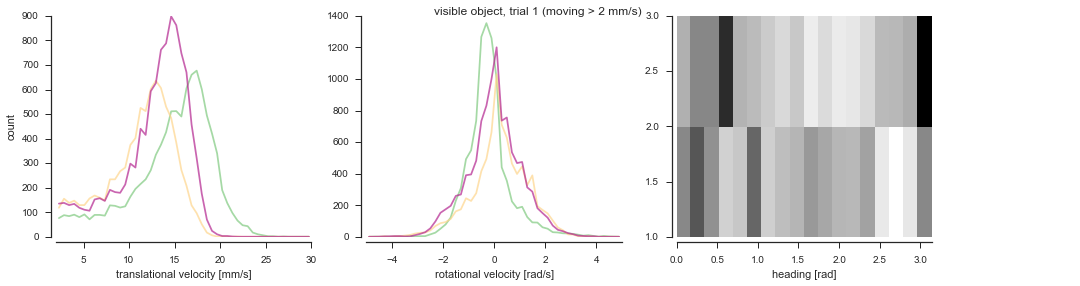

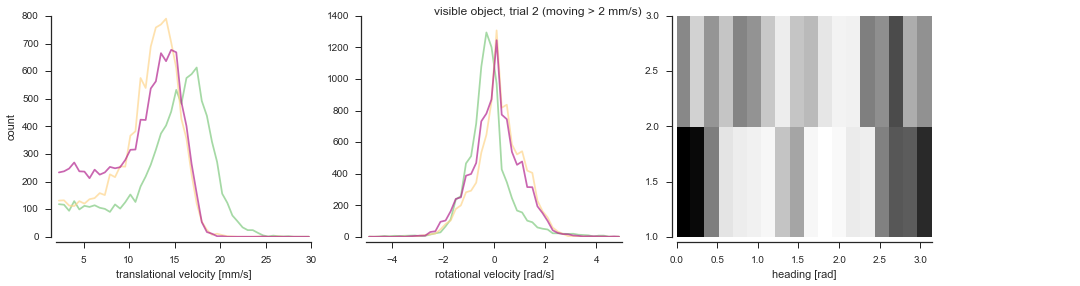

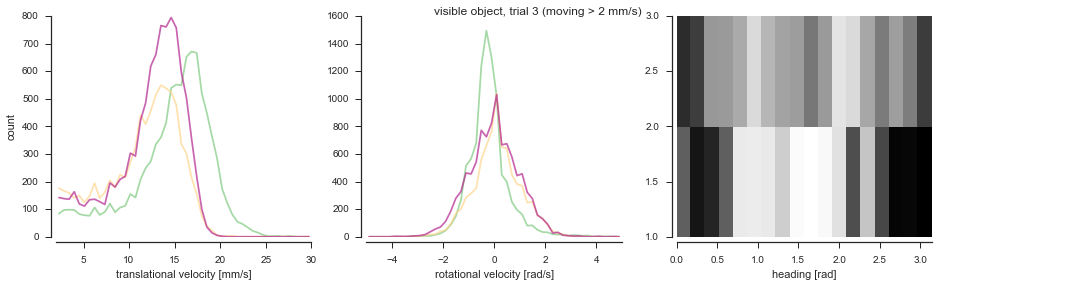

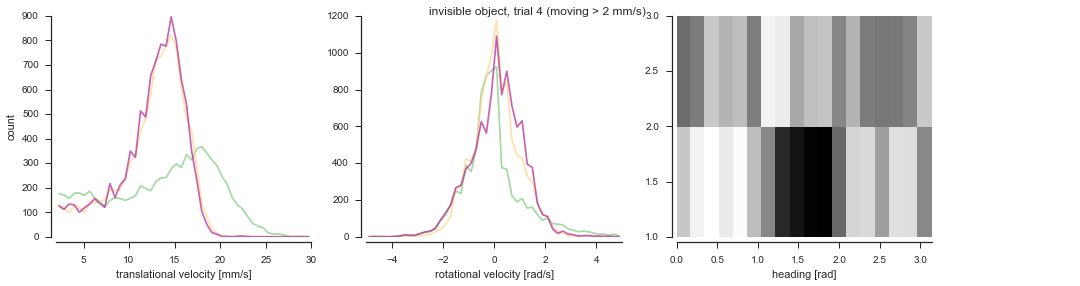

In [508]:
for ttind,trialtype in enumerate(['visible','visible','visible','invisible']):
    
    veloDistFig = plotVeloHeadingDistribution_flyVR_df(FOAllFlies_df, trialtype, str(ttind+1), flyIDs, keylistLong, vTransTH)
    veloDistFig.tight_layout()
    
    #makeNestedPlotDirectory(analysisDir, 'velocityTraces/', objecttype + sep)
    # analysisDir + 'velocityTraces/' should already exist from single trial analysis
    veloDistFig.savefig(analysisDir + 'velocityTraces/'  + genotypeSex + '_' + trialtype
                        + '_veloDistributions_trial' + str(ttind+1) + '_n'+ str(len(flyIDs)) + '.pdf', format='pdf')

### TODO: extract peaks in per-fly heading distribution (maybe for several distances) 

## Residency plots

### 2D residency

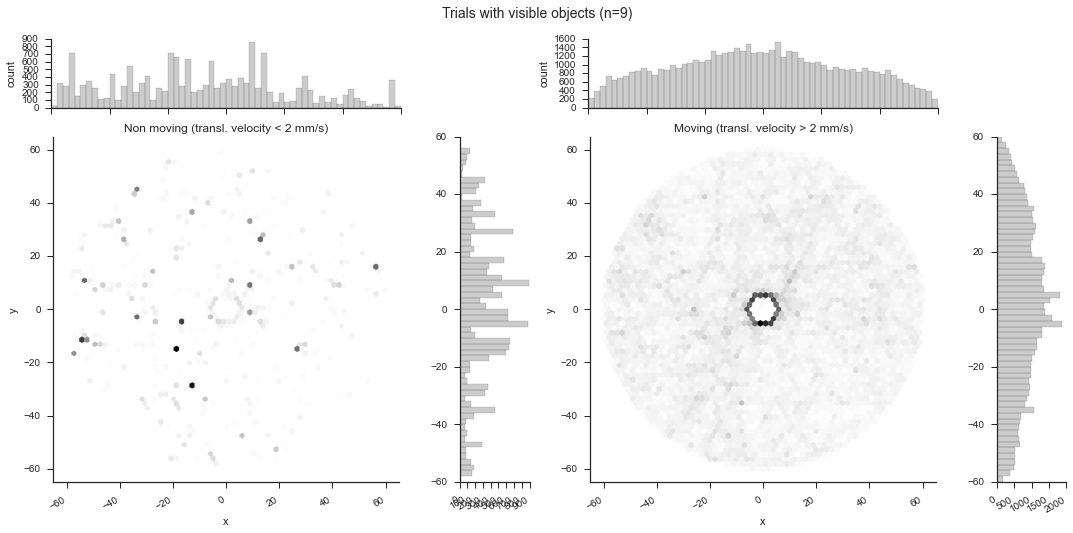

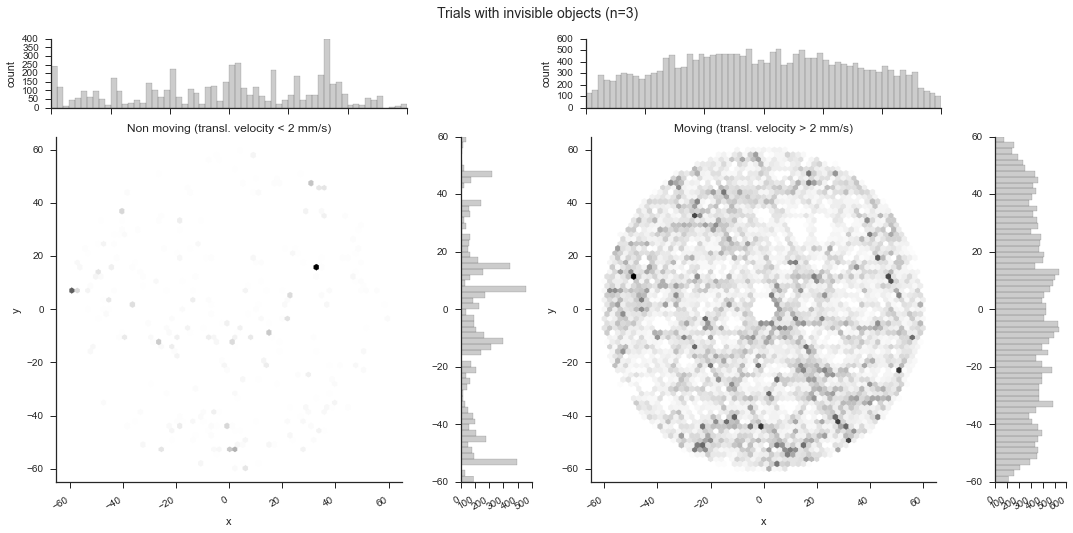

In [509]:
# make fly summary plot of residency:
arenaRad = 60
numBins = 60

keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_vT = keylistLong.index('transVelo')

nTrials = (nTrialsVI,nTrialsIN)

for indcond, condition in enumerate(['visible', 'invisible']):
    querystring = '(trialtype == "' + condition + '")'
    xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    movingall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1]).squeeze().astype('bool')
    vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()

    movingall = vT>vTransTH

    # make plot
    noNans = ~np.isnan(xPosMAall)
    hexplotfig = residencyWithHistograms_splitOnWalking(
        xPosMAall[noNans], yPosMAall[noNans], movingall[noNans], arenaRad, numBins, vTransTH,
        'Trials with ' + condition + ' objects (n=' + str(nTrials[indcond]) + ')')
    
    #makeNestedPlotDirectory(analysisDir, 'velocityTraces/', objecttype + sep)
    # analysisDir + 'residencyPlots/' should already exist from single trial analysis
    hexplotfig.savefig(analysisDir + 'residencyPlots/'  + genotypeSex + '_' + condition
                        + '_residencyMA_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

### 1D resiceny (along readial distance from object)

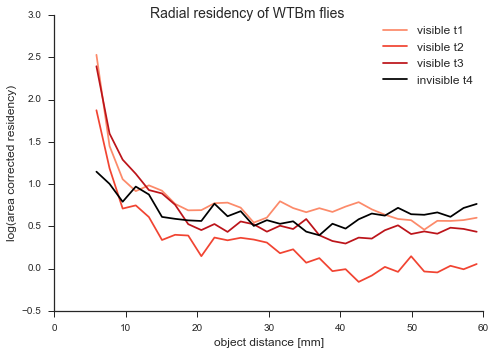

In [510]:
movementFilter = 'moving > 0'
trialConditions = ['visible','visible','visible','invisible']
numBins = 30
histRange = (5,arenaRad)

radResFig = plt.figure(figsize=(7,5))
radResFig.suptitle('Radial residency of '+genotypeSex+' flies',fontsize=14)
radResPlt = radResFig.add_subplot(111)
radResPlt = oneDimResidency_df(radResPlt, FOAllFlies_df, movementFilter, trialConditions, numBins, histRange)
myAxisTheme(radResPlt)
radResFig.tight_layout()

### TODO: plot 1D residency as per-fly histogram for the 4 trials

## TODO: Mean acceleration within object-centric polar coordinate space

## Distance vs. relative heading

In [511]:
def relPolarCoordMeanMap(relPolMeanPlt, distEdges, angleEdges, valuesToMap, objDistance, gamma, colorMap):
    
    # bin valuesToMap by objectDistance value
    digitizedDist = np.digitize(objDistance, distEdges)

    # bin valuesToMap by objectDistance value
    digitizedAngle = np.digitize(gamma, angleEdges)

    meanVals = 1.0*np.zeros((len(angleEdges),len(distEdges)))

    for distBin in range(1, 1+len(distEdges)):
        for angleBin in range(1, 1+len(angleEdges)):
            sltPts = np.logical_and(digitizedDist==distBin, digitizedAngle==angleBin)
            if sum(sltPts) > 0:
                meanVals[angleBin-1,distBin-1,] = np.mean(valuesToMap[sltPts])
    
    maxValue = np.max(np.abs(meanVals))
    pc = relPolMeanPlt.pcolormesh(distEdges, angleEdges, meanVals, cmap = colorMap, vmin=-maxValue, vmax=maxValue)
    relPolMeanPlt.set_xlim(min(distEdges), max(distEdges))
    relPolMeanPlt.set_ylim(min(angleEdges), max(angleEdges))
    relPolMeanPlt.set_xlabel('radial distance from object [mm]')
    relPolMeanPlt.set_ylabel('absolut angle relative to object [deg]')

    return relPolMeanPlt, meanVals, pc

In [512]:
def relPolarCoordMedianMap(relPolMeanPlt, distEdges, angleEdges, valuesToMap, objDistance, gamma, colorMap):
    
    # bin valuesToMap by objectDistance value
    digitizedDist = np.digitize(objDistance, distEdges)

    # bin valuesToMap by objectDistance value
    digitizedAngle = np.digitize(gamma, angleEdges)

    meanVals = 1.0*np.zeros((len(angleEdges),len(distEdges)))

    for distBin in range(1, 1+len(distEdges)):
        for angleBin in range(1, 1+len(angleEdges)):
            sltPts = np.logical_and(digitizedDist==distBin, digitizedAngle==angleBin)
            if sum(sltPts) > 0:
                meanVals[angleBin-1,distBin-1,] = np.median(valuesToMap[sltPts])
    
    maxValue = np.max(np.abs(meanVals))
    pc = relPolMeanPlt.pcolormesh(distEdges, angleEdges, meanVals, cmap = colorMap, vmin=-maxValue, vmax=maxValue)
    relPolMeanPlt.set_xlim(min(distEdges), max(distEdges))
    relPolMeanPlt.set_ylim(min(angleEdges), max(angleEdges))
    relPolMeanPlt.set_xlabel('radial distance from object [mm]')
    relPolMeanPlt.set_ylabel('absolut angle relative to object [deg]')

    return relPolMeanPlt, meanVals, pc

In [ ]:
def ....

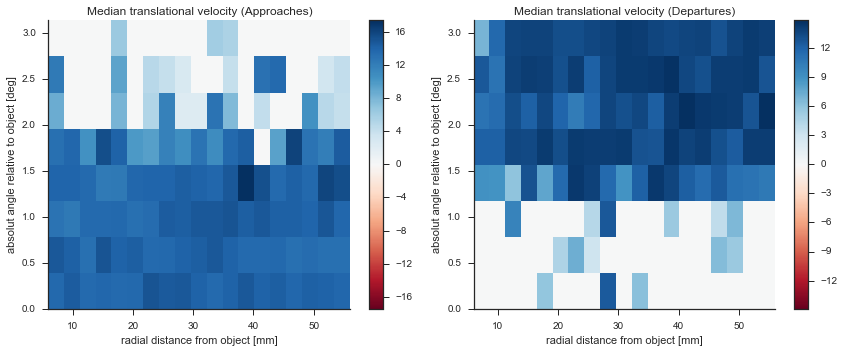

In [513]:
distEdges = np.linspace(6, arenaRad-4, 20)
angleEdges = np.linspace(0, np.pi, 9)

trialtype = 'visible'
trial = 2

querystring = '(moving > 0) & (objectDistance>6)&(trialtype == "'+trialtype+'") & (trial == '+str(trial)+')'
xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
time = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()

objDistanceall = np.hypot(xPosMAall, yPosMAall)

d_objDist = np.hstack((0, np.diff(np.convolve(objDistanceall, np.ones((7,))/7, mode='same'))))

# split data roughly into 'approaches' and 'departues'
approaches = d_objDist<0
departures = d_objDist>0

relPolMeanFig = plt.figure(figsize = (12,5))
relPolMeanPlt = relPolMeanFig.add_subplot(121)
relPolMeanPlt, meanVals, pc = relPolarCoordMedianMap(relPolMeanPlt, distEdges, angleEdges,
                                               vT[approaches], objDistanceall[approaches], gammaall[approaches],
                                               'RdBu')
myAxisTheme(relPolMeanPlt)
relPolMeanFig.colorbar(pc)
relPolMeanPlt.set_title('Median translational velocity (Approaches)')

relPolMeanPlt = relPolMeanFig.add_subplot(122)
relPolMeanPlt, meanVals, pc = relPolarCoordMedianMap(relPolMeanPlt, distEdges, angleEdges,
                                               vT[departures], objDistanceall[departures], gammaall[departures],
                                               'RdBu')
myAxisTheme(relPolMeanPlt)
relPolMeanFig.colorbar(pc)
relPolMeanPlt.set_title('Median translational velocity (Departures)')

relPolMeanFig.tight_layout()

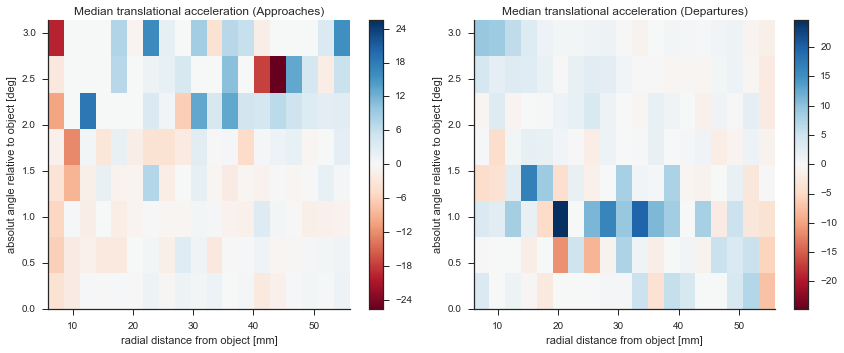

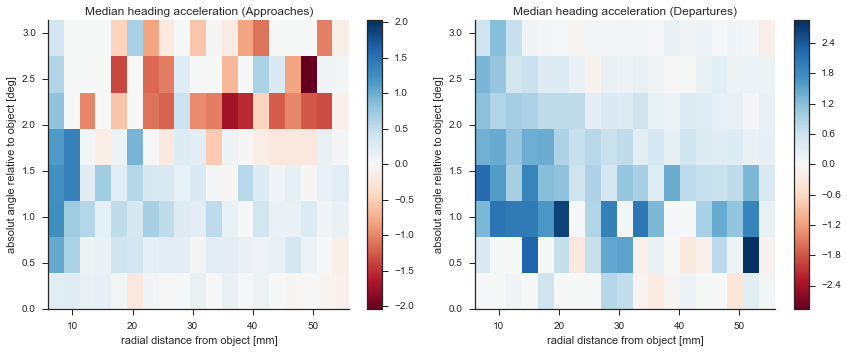

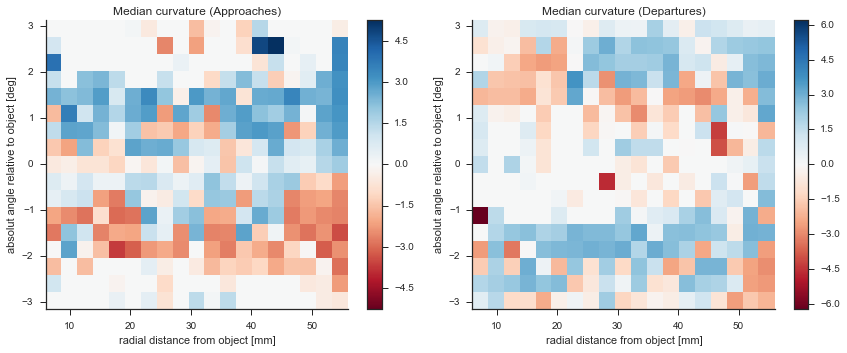

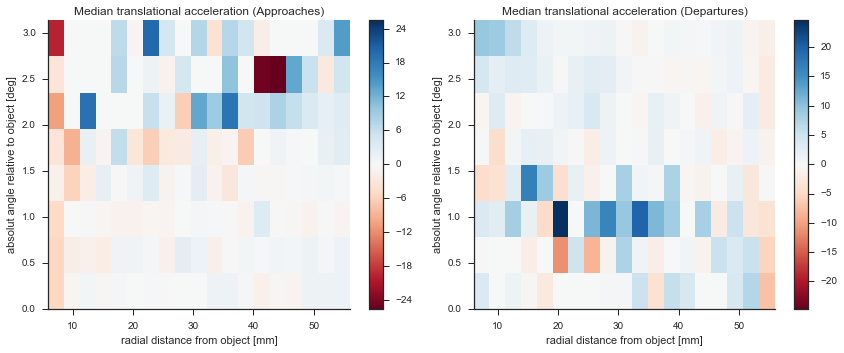

In [526]:
minDist = 6
maxDist = 56
distEdges = np.linspace(minDist, maxDist, 20)
angleEdges = np.linspace(0, np.pi, 9)

trialtype = 'visible'

querystring = '(moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+\
                ') & (trialtype == "'+ trialtype +'") & (trial < 3)' 

xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
time = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()

objDistanceall = np.hypot(xPosMAall, yPosMAall)

d_objDist = np.hstack((0, np.diff(np.convolve(objDistanceall, np.ones((7,))/7, mode='same'))))

# split data roughly into 'approaches' and 'departues'
approaches = d_objDist<0
departures = d_objDist>0

# Plot for heading angle change
d_gamma = np.hstack((0, np.diff(gammaall)/np.diff(time)))
d_gamma = np.convolve(d_gamma, np.ones((7,))/7, mode='same')

relPolMeanFig = plt.figure(figsize = (12,5))
relPolMeanPlt = relPolMeanFig.add_subplot(121)
relPolMeanPlt, meanVals, pc = relPolarCoordMedianMap(relPolMeanPlt, distEdges, angleEdges,
                                               d_gamma[approaches], objDistanceall[approaches], gammaall[approaches],
                                               'RdBu')
myAxisTheme(relPolMeanPlt)
relPolMeanFig.colorbar(pc)
relPolMeanPlt.set_title('Median heading acceleration (Approaches)')

relPolMeanPlt = relPolMeanFig.add_subplot(122)
relPolMeanPlt, meanVals, pc = relPolarCoordMedianMap(relPolMeanPlt, distEdges, angleEdges,
                                               d_gamma[departures], objDistanceall[departures], gammaall[departures],
                                               'RdBu')
myAxisTheme(relPolMeanPlt)
relPolMeanFig.colorbar(pc)
relPolMeanPlt.set_title('Median heading acceleration (Departures)')

relPolMeanFig.tight_layout()

# Plot for curvature
# transform trajectory to polar coordinates
objDist,theta = cartesian2polar(xPosMAall,yPosMAall)

# compute curvature
polarCurv, d_theta, dtheta_objDist = polarCurvature(theta,objDist)
# Compute sign of turn relative to object
turnSign = np.sign(polarCurv)
turnSign[d_theta>0] = np.sign(polarCurv[d_theta>0])
turnSign[d_theta<0] = -np.sign(polarCurv[d_theta<0])
#correct curvature
curvmag = abs(np.convolve(polarCurv, np.ones((10,))/10, mode='same'))
corCurv = turnSign*np.log(curvmag)

angleEdges = np.linspace(-np.pi, np.pi, 18)

relPolMeanFig = plt.figure(figsize = (12,5))
relPolMeanPlt = relPolMeanFig.add_subplot(121)
relPolMeanPlt, meanVals, pc = relPolarCoordMedianMap(relPolMeanPlt, distEdges, angleEdges,
                                               corCurv[approaches], objDistanceall[approaches], gammaFullall[approaches],
                                               'RdBu')
myAxisTheme(relPolMeanPlt)
relPolMeanFig.colorbar(pc)
relPolMeanPlt.set_title('Median curvature (Approaches)')

relPolMeanPlt = relPolMeanFig.add_subplot(122)
relPolMeanPlt, meanVals, pc = relPolarCoordMedianMap(relPolMeanPlt, distEdges, angleEdges,
                                               corCurv[departures], objDistanceall[departures], gammaFullall[departures],
                                               'RdBu')
myAxisTheme(relPolMeanPlt)
relPolMeanFig.colorbar(pc)
relPolMeanPlt.set_title('Median curvature (Departures)')

relPolMeanFig.tight_layout()


d_vT = np.hstack((0, np.diff(np.convolve(vT, np.ones((5,))/5, mode='same'))/np.diff(time)))
d_vT = np.convolve(d_vT, np.ones((5,))/5, mode='same')
d_vT[abs(d_vT)>2*np.std(abs(d_vT))] = np.sign(d_vT[abs(d_vT)>2*np.std(abs(d_vT))])*2*np.std(abs(d_vT))

distEdges = np.linspace(6, arenaRad-4, 20)
angleEdges = np.linspace(0, np.pi, 9)

relPolMeanFig = plt.figure(figsize = (12,5))
relPolMeanPlt = relPolMeanFig.add_subplot(121)
relPolMeanPlt, meanVals, pc = relPolarCoordMedianMap(relPolMeanPlt, distEdges, angleEdges,
                                               d_vT[approaches], objDistanceall[approaches], gammaall[approaches],
                                               'RdBu')
myAxisTheme(relPolMeanPlt)
relPolMeanFig.colorbar(pc)
relPolMeanPlt.set_title('Median translational acceleration (Approaches)')

relPolMeanPlt = relPolMeanFig.add_subplot(122)
relPolMeanPlt, meanVals, pc = relPolarCoordMedianMap(relPolMeanPlt, distEdges, angleEdges,
                                               d_vT[departures], objDistanceall[departures], gammaall[departures],
                                               'RdBu')
myAxisTheme(relPolMeanPlt)
relPolMeanFig.colorbar(pc)
relPolMeanPlt.set_title('Median translational acceleration (Departures)')

relPolMeanFig.tight_layout()

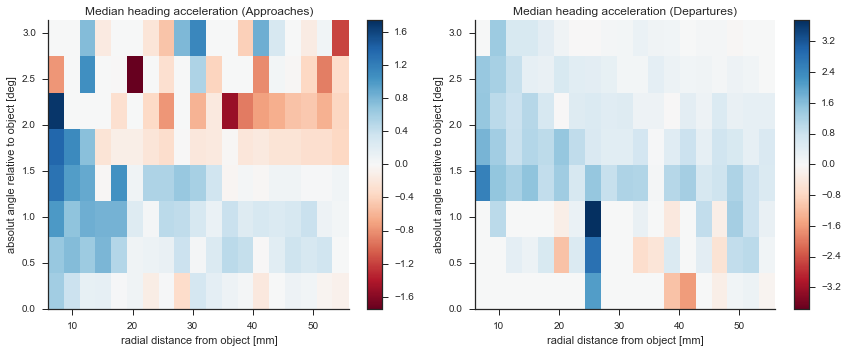

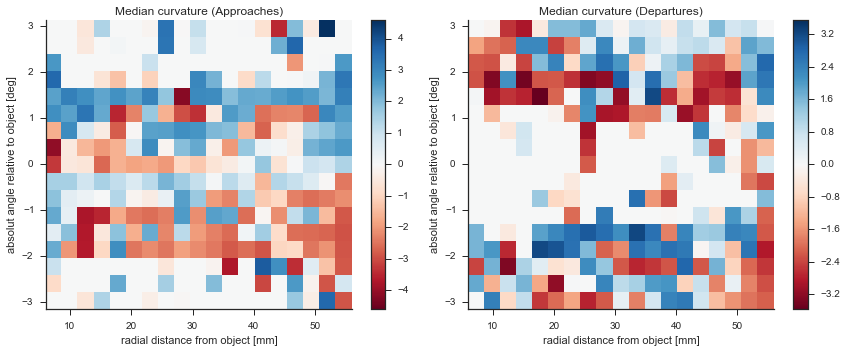

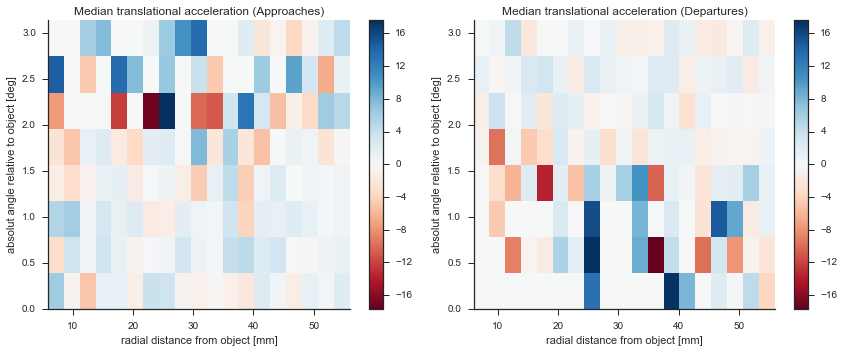

In [527]:
minDist = 6
maxDist = 56
distEdges = np.linspace(minDist, maxDist, 20)
angleEdges = np.linspace(0, np.pi, 9)

trialtype = 'invisible'
trial = 4


querystring = '(moving > 0) & (objectDistance>'+str(minDist)+') & (objectDistance<'+str(maxDist)+\
                ') & (trialtype == "'+ trialtype +'")' 
    
xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
gammaFullall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
vT = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
time = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()

objDistanceall = np.hypot(xPosMAall, yPosMAall)

d_objDist = np.hstack((0, np.diff(np.convolve(objDistanceall, np.ones((7,))/7, mode='same'))))

# split data roughly into 'approaches' and 'departues'
approaches = d_objDist<0
departures = d_objDist>0

# Plot for heading angle change
d_gamma = np.hstack((0, np.diff(gammaall)/np.diff(time)))
d_gamma = np.convolve(d_gamma, np.ones((7,))/7, mode='same')

relPolMeanFig = plt.figure(figsize = (12,5))
relPolMeanPlt = relPolMeanFig.add_subplot(121)
relPolMeanPlt, meanVals, pc = relPolarCoordMedianMap(relPolMeanPlt, distEdges, angleEdges,
                                               d_gamma[approaches], objDistanceall[approaches], gammaall[approaches],
                                               'RdBu')
myAxisTheme(relPolMeanPlt)
relPolMeanFig.colorbar(pc)
relPolMeanPlt.set_title('Median heading acceleration (Approaches)')

relPolMeanPlt = relPolMeanFig.add_subplot(122)
relPolMeanPlt, meanVals, pc = relPolarCoordMedianMap(relPolMeanPlt, distEdges, angleEdges,
                                               d_gamma[departures], objDistanceall[departures], gammaall[departures],
                                               'RdBu')
myAxisTheme(relPolMeanPlt)
relPolMeanFig.colorbar(pc)
relPolMeanPlt.set_title('Median heading acceleration (Departures)')

relPolMeanFig.tight_layout()


# Plot for curvature
# transform trajectory to polar coordinates
objDist,theta = cartesian2polar(xPosMAall,yPosMAall)

# compute curvature
polarCurv, d_theta, dtheta_objDist = polarCurvature(theta,objDist)
# Compute sign of turn relative to object
turnSign = np.sign(polarCurv)
turnSign[d_theta>0] = np.sign(polarCurv[d_theta>0])
turnSign[d_theta<0] = -np.sign(polarCurv[d_theta<0])
#correct curvature
curvmag = abs(np.convolve(polarCurv, np.ones((10,))/10, mode='same'))
corCurv = turnSign*np.log(curvmag)

angleEdges = np.linspace(-np.pi, np.pi, 18)

relPolMeanFig = plt.figure(figsize = (12,5))
relPolMeanPlt = relPolMeanFig.add_subplot(121)
relPolMeanPlt, meanVals, pc = relPolarCoordMedianMap(relPolMeanPlt, distEdges, angleEdges,
                                               corCurv[approaches], objDistanceall[approaches], gammaFullall[approaches],
                                               'RdBu')
myAxisTheme(relPolMeanPlt)
relPolMeanFig.colorbar(pc)
relPolMeanPlt.set_title('Median curvature (Approaches)')

relPolMeanPlt = relPolMeanFig.add_subplot(122)
relPolMeanPlt, meanVals, pc = relPolarCoordMedianMap(relPolMeanPlt, distEdges, angleEdges,
                                               corCurv[departures], objDistanceall[departures], gammaFullall[departures],
                                               'RdBu')
myAxisTheme(relPolMeanPlt)
relPolMeanFig.colorbar(pc)
relPolMeanPlt.set_title('Median curvature (Departures)')

relPolMeanFig.tight_layout()



d_vT = np.hstack((0, np.diff(np.convolve(vT, np.ones((5,))/5, mode='same'))/np.diff(time)))
d_vT = np.convolve(d_vT, np.ones((5,))/5, mode='same')
d_vT[abs(d_vT)>2*np.std(abs(d_vT))] = np.sign(d_vT[abs(d_vT)>2*np.std(abs(d_vT))])*2*np.std(abs(d_vT))

distEdges = np.linspace(6, arenaRad-4, 20)
angleEdges = np.linspace(0, np.pi, 9)

relPolMeanFig = plt.figure(figsize = (12,5))
relPolMeanPlt = relPolMeanFig.add_subplot(121)
relPolMeanPlt, meanVals, pc = relPolarCoordMedianMap(relPolMeanPlt, distEdges, angleEdges,
                                               d_vT[approaches], objDistanceall[approaches], gammaall[approaches],
                                               'RdBu')
myAxisTheme(relPolMeanPlt)
relPolMeanFig.colorbar(pc)
relPolMeanPlt.set_title('Median translational acceleration (Approaches)')

relPolMeanPlt = relPolMeanFig.add_subplot(122)
relPolMeanPlt, meanVals, pc = relPolarCoordMedianMap(relPolMeanPlt, distEdges, angleEdges,
                                               d_vT[departures], objDistanceall[departures], gammaall[departures],
                                               'RdBu')
myAxisTheme(relPolMeanPlt)
relPolMeanFig.colorbar(pc)
relPolMeanPlt.set_title('Median translational acceleration (Departures)')

relPolMeanFig.tight_layout()

Analysis directory already exists.


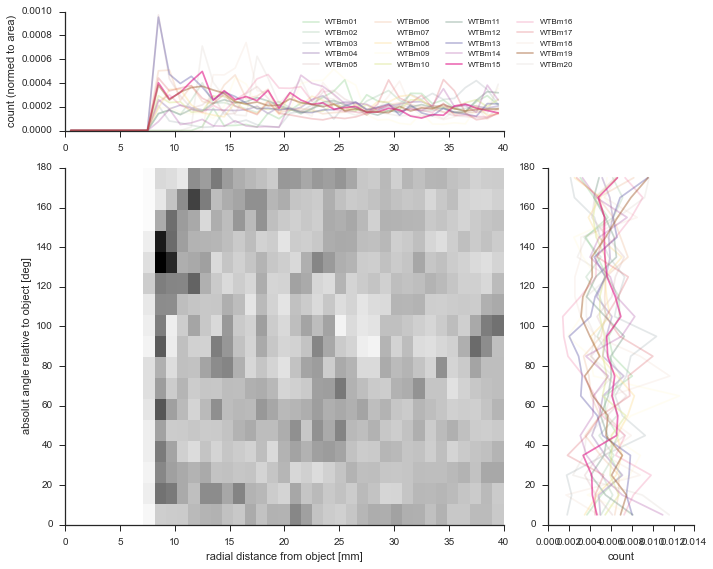

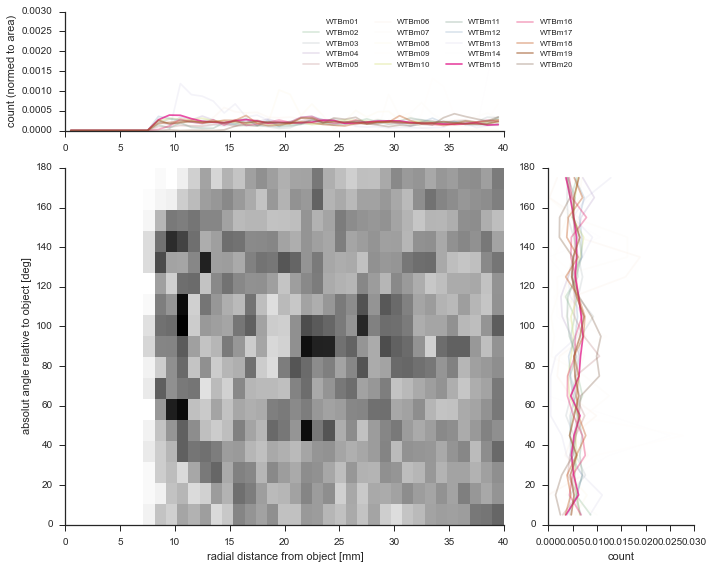

In [267]:
try:
    mkdir(analysisDir + sep + 'headingVsDistance' + sep)
except OSError:
    print('Analysis directory already exists.')

# plot parameter
distBins = 40
angleBins = 18
maxDist = 40#arenaRad

# Note: Line plot alphas are proportional to amount of data the respective fly contrinuted
for ttind,trialtype in enumerate(['visible','invisible']):
    querystring = '(moving > 0) & (objectDistance>8) &(objectDistance < ' + str(maxDist) +\
        ')&(trialtype == "'+ trialtype +'") & (trial == '+ str(ttind+1+ttind*2) +')' 
    xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    gammaall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
    flyIDallarray = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_fly:keyind_fly+1]).squeeze()
    
    objDistanceall = np.hypot(xPosMAall, yPosMAall)
    
    headingDistFig = radDistAngleCombiPlot(distBins,angleBins,maxDist,flyIDs,flyIDallarray,objDistanceall,gammaall)

    headingDistFig.savefig(analysisDir + 'headingVsDistance/'  + genotypeSex + '_' + trialtype
                           + '_headingVsDistanceHist_trial'+ str(ttind+1+ttind*2) +'_n'+ str(len(flyIDs)) +'.pdf',
                           format='pdf')

## Comparison between trials

Analysis directory already exists.


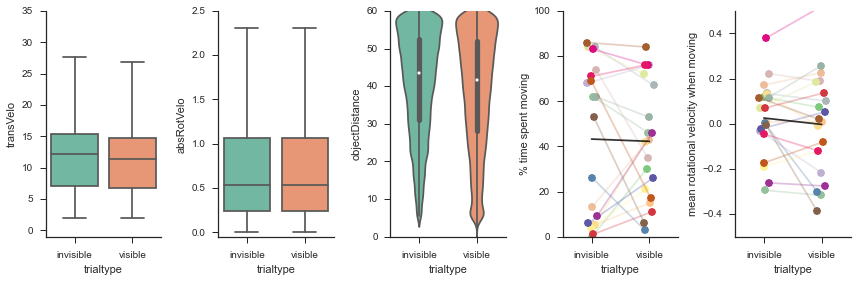

In [250]:
FOAllFliesMoving_df = FOAllFlies_df.query('(moving > 0)')
FOAllFliesMoving_df = FOAllFliesMoving_df[keylistLong]
FOAllFliesMoving_df.insert(0, 'absRotVelo', abs(FOAllFliesMoving_df['rotVelo']))

perTrialBP = plt.figure(figsize=(12,4))

perTrialBPvT = perTrialBP.add_subplot(151)
sns.boxplot(x='trialtype', y='transVelo', 
            data=FOAllFliesMoving_df, palette='Set2',sym='')
perTrialBPvT.set_ylim(-1,35)
myAxisTheme(perTrialBPvT)

perTrialBPvR = perTrialBP.add_subplot(152)
sns.boxplot(x='trialtype', y='absRotVelo',
            data=FOAllFliesMoving_df, palette='Set2',sym='')
perTrialBPvR.set_ylim(-0.05,2.5)
myAxisTheme(perTrialBPvR)

perTrialVPod = perTrialBP.add_subplot(153)
sns.violinplot(x='trialtype', y='objectDistance', data=FOAllFliesMoving_df,
               palette='Set2',sym='', bw=.1)
               #,inner='stick',  scale='count')
perTrialVPod.set_ylim(0,arenaRad)
myAxisTheme(perTrialVPod)

percentMoving = np.zeros((numFlies,2))
rotationBias = np.zeros((numFlies,2))
randJitter = np.zeros((numFlies,2))

perFlyMovingPlt = perTrialBP.add_subplot(154)
plt.xticks([1,2], ["invisible","visible"], rotation='horizontal')
perFlyRotBiasPlt = perTrialBP.add_subplot(155)
plt.xticks([1,2], ["invisible","visible"], rotation='horizontal')

for fly in range(numFlies):
    for ttind,trialtype in enumerate(["invisible","visible"]):
        querystring = '(trialtype == "' + trialtype + '") & (flyID == "' + flyIDs[fly] +  '")'
        perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('bool')
        perFlyRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float')        
        jitter = np.random.uniform(-0.1, 0.1)
        percentMoving[fly,ttind] = 100*sum(perFlyMoving)/max(1,len(perFlyMoving))
        rotationBias[fly,ttind] = np.mean(perFlyRot[perFlyMoving])
        randJitter[fly,ttind] = jitter
        perFlyMovingPlt.plot(ttind+1+jitter,percentMoving[fly,ttind],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))
        perFlyRotBiasPlt.plot(ttind+1+jitter,rotationBias[fly,ttind],'.',
                              markersize=15,color = flyCMap.to_rgba(fly))

    perFlyMovingPlt.plot(range(1,3)+randJitter[fly,:] ,percentMoving[fly,:],'-',
                         markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
    perFlyRotBiasPlt.plot(range(1,3)+randJitter[fly,:] ,rotationBias[fly,:],'-',
                          markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)
#plot average response
perFlyMovingPlt.plot(range(1,3),np.mean(percentMoving,axis=0),color='k',alpha=0.8)
perFlyRotBiasPlt.plot(range(1,3),np.mean(rotationBias,axis=0),color='k',alpha=0.8)

perFlyMovingPlt.set_ylim(0,100)
perFlyMovingPlt.set_xlim(0.5,2.5)
perFlyMovingPlt.set_xlabel('trialtype')
perFlyMovingPlt.set_ylabel('% time spent moving')
myAxisTheme(perFlyMovingPlt)

perFlyRotBiasPlt.set_ylim(-0.5,0.5)
perFlyRotBiasPlt.set_xlim(0.5,2.5)
perFlyRotBiasPlt.set_xlabel('trialtype')
perFlyRotBiasPlt.set_ylabel('mean rotational velocity when moving')
myAxisTheme(perFlyRotBiasPlt)

perTrialBP.tight_layout()

try:
    mkdir(analysisDir + sep + 'compareTrialtypes' + sep)
except OSError:
    print('Analysis directory already exists.')

perTrialBP.savefig(analysisDir + 'compareTrialtypes/'  + genotypeSex
                   + '_visibleVSinvisible_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

### TODO: Change plot
#### --> merge residency plots into one 1D plot with all trials
#### --> plot per-fly mean distance

Analysis directory already exists.


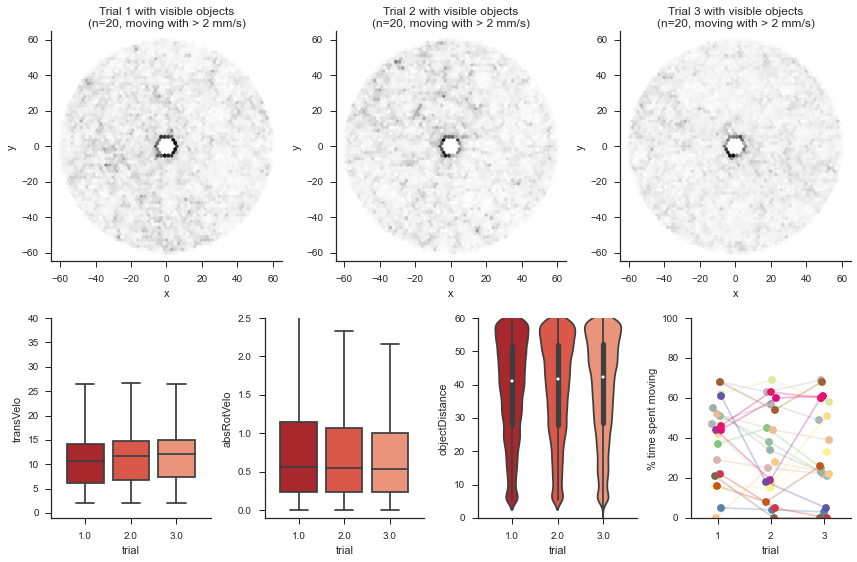

In [251]:
# make fly summary plot of residency:
arenaRad = 60
numBins = 60

trialComparisonFig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,12,height_ratios=[1,0.8])
numVItrials = 3
for trial in range(1,numVItrials+1):
    querystring = '(trial == ' + str(trial) + ')'
    xPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosMAall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    movingall = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1]).squeeze().astype('bool')

    # make plot
    sbplt = trialComparisonFig.add_subplot(gs[0,(trial-1)*4:trial*4]) #(1,numVItrials,trial)
    
    noNans = ~np.isnan(xPosMAall)
    titlestring = 'Trial '+str(trial)+' with visible objects\n(n='+str(nTrialsVI/numVItrials)+', moving with > '+str(vTransTH)+' mm/s)'

    hexplotfig_trial = plotResidencyInMiniarena(sbplt, xPosMAall[noNans][movingall[noNans]],
                                                yPosMAall[noNans][movingall[noNans]],numBins, arenaRad,
                                                'Greys',titlestring)

FOAllFliesVisible_df = FOAllFlies_df.query('(trialtype == "visible") & (trial < 4) & (moving > 0)')
FOAllFliesVisible_df = FOAllFliesVisible_df[keylistLong]

FOAllFliesVisible_df.insert(keylistLong.index('rotVelo'), 'absRotVelo', abs(FOAllFliesVisible_df['rotVelo']))

#perTrialBP = plt.figure(figsize=(13,4))
perTrialBPvT = trialComparisonFig.add_subplot(gs[1,0:3])
sns.boxplot(x='trial', y='transVelo', 
            data=FOAllFliesVisible_df, palette='Reds_r',sym='')
perTrialBPvT.set_ylim(-1,40)
perTrialBPvT.set_xlim(-0.75,2.75)
myAxisTheme(perTrialBPvT)

perTrialBPvR = trialComparisonFig.add_subplot(gs[1,3:6])
sns.boxplot(x='trial', y='absRotVelo',
            data=FOAllFliesVisible_df, palette='Reds_r',sym='')
perTrialBPvR.set_ylim(-0.1,2.5)
perTrialBPvR.set_xlim(-0.75,2.75)
myAxisTheme(perTrialBPvR)

perTrialVPod = trialComparisonFig.add_subplot(gs[1,6:9])
sns.violinplot(x='trial', y='objectDistance',data=FOAllFliesVisible_df,
               palette='Reds_r',sym='', bw=.1)
perTrialVPod.set_ylim(0,arenaRad)
perTrialVPod.set_xlim(-0.75,2.75)
myAxisTheme(perTrialVPod)

percentMoving = np.zeros((numFlies,3))
randJitter = np.zeros((numFlies,3))

perFlyMovingPlt = trialComparisonFig.add_subplot(gs[1,9:12])

for fly in range(numFlies):
    for trial in range(3):
        querystring = '(trialtype == "visible") & (trial == ' + str(trial+1) + ') & (flyID == "'+ flyIDs[fly] +  '")'
        #perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze().astype('int')        
        perFlyMoving = FOAllFlies_df.query(querystring).iloc[:,keyind_walk:keyind_walk+1].squeeze().astype('int')
        jitter = np.random.uniform(-0.1, 0.1)
        percentMoving[fly,trial] = 100*sum(perFlyMoving)/max(1,len(perFlyMoving))
        randJitter[fly,trial] = jitter
        perFlyMovingPlt.plot(trial+1+jitter,percentMoving[fly,trial],'.',
                             markersize=15,color = flyCMap.to_rgba(fly))

    perFlyMovingPlt.plot(range(1,4)+randJitter[fly,:],percentMoving[fly,:],
                         '-',markersize=15,color = flyCMap.to_rgba(fly), alpha=0.3)

perFlyMovingPlt.set_xlabel('trial')
plt.xticks([1,2,3],[1,2,3], rotation='horizontal')
perFlyMovingPlt.set_ylabel('% time spent moving')
perFlyMovingPlt.set_ylim(0,100)
perFlyMovingPlt.set_xlim(0.5,3.5)
myAxisTheme(perFlyMovingPlt)

trialComparisonFig.tight_layout()

try:
    mkdir(analysisDir + sep + 'compareVisibleTrials' + sep)
except OSError:
    print('Analysis directory already exists.')

trialComparisonFig.savefig(analysisDir + 'compareVisibleTrials/'  + genotypeSex
                   + '_visibleTrials'+'_n'+ str(len(flyIDs)) +'.pdf', format='pdf')

### Analysis of visits to the object

#### TODO: extract visits & plot trajectories prior to that

In [426]:
condition = "visible"
trial = 2
querystring = '(trialtype=="'+condition+'") & (trial=='+ str(trial) +') & (walking>0) & (objectDistance>6)'# & ((flyID== "WTBm10"))'
xPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1]).squeeze()
timeFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()
walkingFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_walk:keyind_walk+1]).squeeze()

objDist = np.hypot(xPosFly,yPosFly)
theta = np.arctan2(yPosFly,xPosFly)

d_objDist = np.hstack((0, np.diff(np.convolve(objDist, np.ones((7,))/7, mode='same'))))
d_objDist[d_objDist>2] = 2
d_objDist[d_objDist<-2] = -2

d_gamma = np.hstack((0, np.diff(np.convolve(gammaFly, np.ones((7,))/7, mode='same'))))

(0, 100)

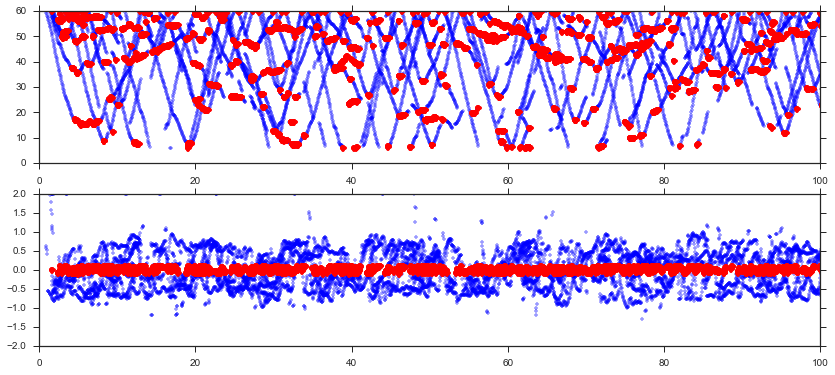

In [427]:
plt.figure(figsize=(14,6))
plt.subplot(211)
plt.plot(timeFly, objDist,'b.',alpha=0.4)
plt.plot(timeFly[abs(d_objDist)<0.1], objDist[abs(d_objDist)<0.1],'ro')
plt.plot(timeFly[objDist<6], objDist[objDist<6],'co')
plt.xlim(0,100)

plt.subplot(212)
plt.plot(timeFly, d_objDist,'b.',alpha=0.4)
plt.plot(timeFly[abs(d_objDist)<0.1], d_objDist[abs(d_objDist)<0.1],'ro')
plt.plot(timeFly[objDist<6], d_objDist[objDist<6],'co')
plt.xlim(0,100)

In [428]:
# extract indices of approach start and end

In [436]:
apr_pts = np.logical_and(filtddist<0, walkingFly>0)
apr_pts = np.logical_and(filtddist>0, walkingFly>0)

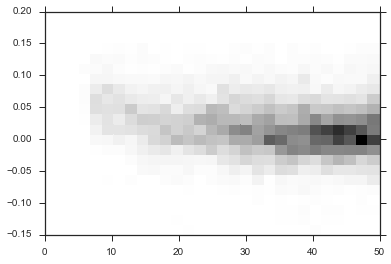

In [437]:
plt.figure(figsize = (12,5))
distEdges = np.linspace(0,50,30)
angleEdges = np.linspace(-0.15,0.15,20)

plt.subplot(121)
n, xedges, yedges = np.histogram2d(objDist[apr_pts], d_gamma[apr_pts], bins=(distEdges, angleEdges))
X, Y = np.meshgrid(yedges, xedges)
plt.pcolormesh(Y, X, n,cmap='Greys')
plt.subplot(122)
n, xedges, yedges = np.histogram2d(objDist[dep_pts], d_gamma[dep_pts], bins=(distEdges, angleEdges))
X, Y = np.meshgrid(yedges, xedges)
plt.pcolormesh(Y, X, n,cmap='Greys')

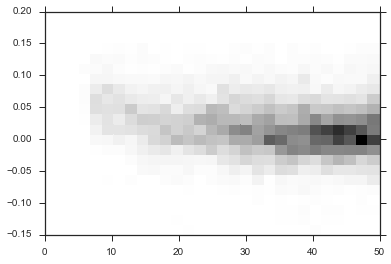

#### Chop trace at points where object distance doesn't change much (d_objectDist = 0)

In [ ]:

for Tpt in range(len(timeFly)):
    if abs(d_objDist)<0.1


In [420]:
# TODO generate "test data", e.g. equidistant parallel lines crossing the miniarena

In [421]:
# TODO compare output of old procedural code below to output of function-based code

### Convert trajectory to polar coordinates and visualise trace and effect of turns

#### TODO: tidy up code

In [473]:
# Calculate turn threshold
# Only include moving flies
querystring = '(walking > 0)'
vRot = FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1].squeeze().astype('float').values
time = FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1].squeeze().astype('float').values

# Find turnTH over all flies
vRot_filt = np.convolve(vRot, np.ones((5,))/5, mode='same')
turnTH_pos = 3*np.std(vRot_filt[vRot_filt>=0])
turnTH_neg = -3*np.std(vRot_filt[vRot_filt<=0])
turnTH = 3*np.std(abs(vRot_filt))

Analysis directory already exists.


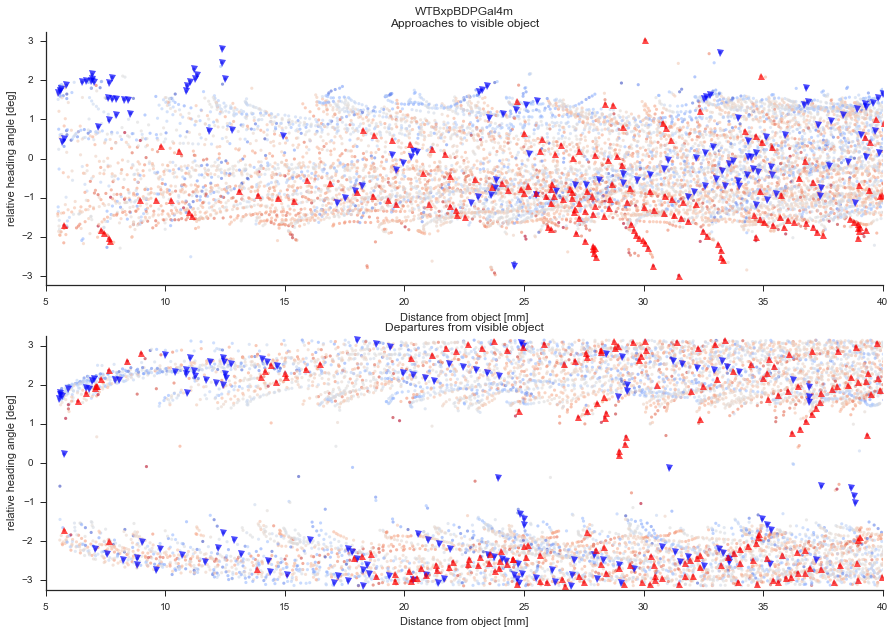

In [474]:
objecttype = "visible"
trial = 1
querystring = '(trialtype=="'+objecttype+'") & (trial=='+ str(trial) +') & (walking>0) & (objectDistance>5.5)'
xPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaFullFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
timeFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()
vTransFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
vRotFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1]).squeeze()

# transform trajectory to polar coordinates
objDist,theta = cartesian2polar(xPosFly,yPosFly)

# compute curvature
polarCurv, d_theta, dtheta_objDist = polarCurvature(theta,objDist)

d_objDist = np.hstack((0, np.diff(objDist)))

# Compute sign of turn relative to object
turnSign = np.sign(polarCurv)
turnSign[d_theta>0] = np.sign(polarCurv[d_theta>0])
turnSign[d_theta<0] = -np.sign(polarCurv[d_theta<0])

# Compute curvature-based criterion for turns
q2, q98 = np.percentile(polarCurv[~np.isnan(polarCurv)], [2 ,98])
curvSelect = abs(polarCurv)< (q98 - q2)/2

curvTurnMask_L = polarCurv > q98
curvTurnMask_R = polarCurv < q2

# Generate filtered curvature for plots and curvature magnitude
polarCurvPlt = polarCurv[curvSelect]

curvMag = abs(polarCurv)

correctedPolarCurv = abs(polarCurv)*turnSign

# Plot
vRotFly_filt = np.convolve(vRotFly, np.ones((5,))/5, mode='same')

titleString = genotypeSex

selectPts_apr = d_objDist<0
selectPts_dep = d_objDist>0

selectPts_apr_turn = np.logical_and(selectPts_apr,abs(vRotFly_filt) > turnTH)
selectPts_apr_turnR = np.logical_and(selectPts_apr,vRotFly_filt < turnTH_neg)
selectPts_apr_turnL = np.logical_and(selectPts_apr,vRotFly_filt > turnTH_pos)

selectPts_dep_turn = np.logical_and(selectPts_dep,abs(vRotFly_filt) > turnTH)
selectPts_dep_turnR = np.logical_and(selectPts_dep,vRotFly_filt < turnTH_neg)
selectPts_dep_turnL = np.logical_and(selectPts_dep,vRotFly_filt > turnTH_pos)

fig = plt.figure(figsize=(15,10))

xlimRange = (5,40)

ax=fig.add_subplot(211)
ax = plotPolarTrace(ax,titleString + '\nApproaches to ' + objecttype + ' object',
                selectPts_apr,selectPts_apr_turnR,selectPts_apr_turnL,objDist,gammaFullFly,vRotFly,xlimRange)

ax=fig.add_subplot(212)
ax = plotPolarTrace(ax,'Departures from '+ objecttype + ' object',
                selectPts_dep,selectPts_dep_turnR,selectPts_dep_turnL,objDist,gammaFullFly,vRotFly,xlimRange)

try:
    mkdir(analysisDir + sep + 'polarTrace' + sep)
except OSError:
    print('Analysis directory already exists.')

fig.savefig(analysisDir + 'polarTrace/'+genotypeSex+'_'+objecttype+'Objects'+'_n'+ str(len(flyIDs))
            +'_polarTrace_trial' + str(trial) + '.pdf', format='pdf')


Analysis directory already exists.


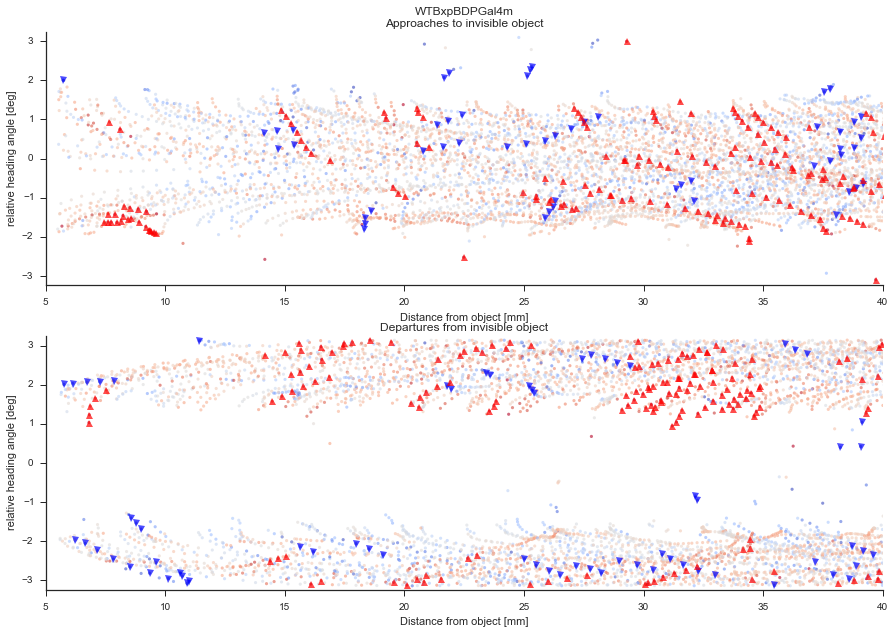

In [424]:
objecttype = "invisible"
trial = 4
querystring = '(trialtype=="'+objecttype+'") & (trial=='+ str(trial) +') & (walking>0) & (objectDistance>5.5)'
xPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
yPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
gammaFullFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1]).squeeze()
timeFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_t:keyind_t+1]).squeeze()
vTransFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
vRotFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1]).squeeze()

# transform trajectory to polar coordinates
objDist,theta = cartesian2polar(xPosFly,yPosFly)

# compute curvature
polarCurv, d_theta, dtheta_objDist = polarCurvature(theta,objDist)

d_objDist = np.hstack((0, np.diff(objDist)))

# Compute sign of turn relative to object
turnSign = np.sign(polarCurv)
turnSign[d_theta>0] = np.sign(polarCurv[d_theta>0])
turnSign[d_theta<0] = -np.sign(polarCurv[d_theta<0])

# Compute curvature-based criterion for turns
q2, q98 = np.percentile(polarCurv[~np.isnan(polarCurv)], [2 ,98])
curvSelect = abs(polarCurv)< (q98 - q2)/2

curvTurnMask_L = polarCurv > q98
curvTurnMask_R = polarCurv < q2

# Generate filtered curvature for plots and curvature magnitude
polarCurvPlt = polarCurv[curvSelect]

curvMag = abs(polarCurv)

correctedPolarCurv = abs(polarCurv)*turnSign

# Plot
vRotFly_filt = np.convolve(vRotFly, np.ones((5,))/5, mode='same')

titleString = genotypeSex

selectPts_apr = d_objDist<0
selectPts_dep = d_objDist>0

selectPts_apr_turn = np.logical_and(selectPts_apr,abs(vRotFly_filt) > turnTH)
selectPts_apr_turnR = np.logical_and(selectPts_apr,vRotFly_filt < turnTH_neg)
selectPts_apr_turnL = np.logical_and(selectPts_apr,vRotFly_filt > turnTH_pos)

selectPts_dep_turn = np.logical_and(selectPts_dep,abs(vRotFly_filt) > turnTH)
selectPts_dep_turnR = np.logical_and(selectPts_dep,vRotFly_filt < turnTH_neg)
selectPts_dep_turnL = np.logical_and(selectPts_dep,vRotFly_filt > turnTH_pos)

fig = plt.figure(figsize=(15,10))

xlimRange = (5,40)

ax=fig.add_subplot(211)
ax = plotPolarTrace(ax,titleString + '\nApproaches to ' + objecttype + ' object',
                selectPts_apr,selectPts_apr_turnR,selectPts_apr_turnL,objDist,gammaFullFly,vRotFly,xlimRange)

ax=fig.add_subplot(212)
ax = plotPolarTrace(ax,'Departures from '+ objecttype + ' object',
                selectPts_dep,selectPts_dep_turnR,selectPts_dep_turnL,objDist,gammaFullFly,vRotFly,xlimRange)

try:
    mkdir(analysisDir + sep + 'polarTrace' + sep)
except OSError:
    print('Analysis directory already exists.')

fig.savefig(analysisDir + 'polarTrace/'+genotypeSex+'_'+objecttype+'Objects'+'_n'+ str(len(flyIDs))
            +'_polarTrace_trial' + str(trial) + '.pdf', format='pdf')

## Turns in relation to object distance

### TODO: try out different turn criterion, e.g. based on turn index (combining vRot and vT)

In [256]:
def getTurnHistCounts(rotationMeasure, objDist, turnTH, turnTH_neg, turnTH_pos, numBins):
    
    d_objDist = np.hstack((0, np.diff(objDist)))
    
    selectPts_apr = d_objDist<0
    selectPts_dep = d_objDist>0

    selectPts_apr_turn = np.logical_and(selectPts_apr,abs(rotationMeasure) > turnTH)
    selectPts_apr_turnR = np.logical_and(selectPts_apr,rotationMeasure < turnTH_neg)
    selectPts_apr_turnL = np.logical_and(selectPts_apr,rotationMeasure > turnTH_pos)

    selectPts_dep_turn = np.logical_and(selectPts_dep,abs(rotationMeasure) > turnTH)
    selectPts_dep_turnR = np.logical_and(selectPts_dep,rotationMeasure < turnTH_neg)
    selectPts_dep_turnL = np.logical_and(selectPts_dep,rotationMeasure > turnTH_pos)

    [nTL_apr,edges] = np.histogram(objDist[selectPts_apr_turnL],bins=numBins,range=(5,55))
    [nTR_apr,edges] = np.histogram(objDist[selectPts_apr_turnR],bins=numBins,range=(5,55))
    [nT_apr,edges] = np.histogram(objDist[selectPts_apr_turn],bins=numBins,range=(5,55))
    [nDt_apr,edges] = np.histogram(objDist[selectPts_apr],bins=numBins,range=(5,55))

    [nTL_dep,edges] = np.histogram(objDist[selectPts_dep_turnL],bins=numBins,range=(5,55))
    [nTR_dep,edges] = np.histogram(objDist[selectPts_dep_turnR],bins=numBins,range=(5,55))
    [nT_dep,edges] = np.histogram(objDist[selectPts_dep_turn],bins=numBins,range=(5,55))
    [nDt_dep,edges] = np.histogram(objDist[selectPts_dep],bins=numBins,range=(5,55))
    
    return nTL_apr, nTL_dep, nTR_apr, nTR_dep, nT_apr, nT_dep, nDt_apr, nDt_dep,edges

In [257]:
def turnRatePerDistance(Fig,FOAllFlies_df,numVisTrials,movementFilter,useTurnIndex):
    legendText = []
    
    keyind_xPos = keylistLong.index('xPosInMiniarena')
    keyind_yPos = keylistLong.index('yPosInMiniarena')
    keyind_vT = keylistLong.index('transVelo')
    keyind_vR = keylistLong.index('rotVelo')
    
    # Find turnTH over all flies
    querystring = '('+movementFilter+') & (objectDistance>5.5)'
    vRot = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1]).squeeze()
    
    if useTurnIndex:
        vTrans = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
        vRot_filt = np.convolve(vRot/vTrans, np.ones((5,))/5, mode='same')
        vRot_filt[np.isinf(abs(vRot_filt))] = 0.0
    else:
        vRot_filt = np.convolve(vRot, np.ones((5,))/5, mode='same')
        
    turnTH_pos = 3*np.nanstd(vRot_filt[vRot_filt>=0])
    turnTH_neg = -3*np.nanstd(vRot_filt[vRot_filt<=0])
    turnTH = 3*np.nanstd(abs(vRot_filt))


    axApr = Fig.add_subplot(121)
    axApr.set_title('Approaches', fontsize=12)
    axDep = Fig.add_subplot(122)
    axDep.set_title('Departures', fontsize=12)

    # visible object ....................................................
    objecttype = "visible"
    numVisTrials = 3
    visAprCMap = plt.cm.ScalarMappable(norm=colors.Normalize(vmin=-1, vmax=numVisTrials),cmap='Blues')
    visDepCMap = plt.cm.ScalarMappable(norm=colors.Normalize(vmin=-1, vmax=numVisTrials),cmap='Greens')
    for trial in range(1,numVisTrials+1):
        querystring = '(trialtype=="'+objecttype+'") & (trial=='+ str(trial) +') & ('+movementFilter+') & (objectDistance>5.5)'
        xPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
        yPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
        vRotFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1]).squeeze()

        objDist,theta = cartesian2polar(xPosFly,yPosFly)
        d_objDist = np.hstack((0, np.diff(objDist)))
        
        if useTurnIndex:
            vTransFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
            vRotFly_filt = np.convolve(vRotFly/vTransFly, np.ones((5,))/5, mode='same')
        else:
            vRotFly_filt = np.convolve(vRotFly, np.ones((5,))/5, mode='same')

        # Get counts
        nTL_apr, nTL_dep, nTR_apr, nTR_dep, nT_apr, nT_dep, nDt_apr, nDt_dep, edges\
            = getTurnHistCounts(vRotFly_filt, objDist, turnTH, turnTH_neg, turnTH_pos, numBins)

        axApr.plot(edges[:-1]+np.mean(np.diff(edges))/2.0,1.0*nT_apr/nDt_apr,color=visAprCMap.to_rgba(trial))
        axDep.plot(edges[:-1]+np.mean(np.diff(edges))/2.0,1.0*nT_dep/nDt_dep,color=visDepCMap.to_rgba(trial))

        legendText.append('visible t'+str(trial))

    # invisible object .................................................
    
    objecttype = "invisible"
    trial = 4
    querystring = '(trialtype=="'+objecttype+'") & (trial=='+ str(trial) +') & ('+movementFilter+') & (objectDistance>5.5)'
    xPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_xPos:keyind_xPos+1]).squeeze()
    yPosFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_yPos:keyind_yPos+1]).squeeze()
    vRotFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vR:keyind_vR+1]).squeeze()

    objDist,theta = cartesian2polar(xPosFly,yPosFly)
    d_objDist = np.hstack((0, np.diff(objDist)))
    
    if useTurnIndex:
        vTransFly = np.asarray(FOAllFlies_df.query(querystring).iloc[:,keyind_vT:keyind_vT+1]).squeeze()
        vRotFly_filt = np.convolve(vRotFly/vTransFly, np.ones((5,))/5, mode='same')
    else:
        vRotFly_filt = np.convolve(vRotFly, np.ones((5,))/5, mode='same')

    # Get counts
    nTL_apr, nTL_dep, nTR_apr, nTR_dep, nT_apr, nT_dep, nDt_apr, nDt_dep, edges\
        = getTurnHistCounts(vRotFly_filt, objDist, turnTH, turnTH_neg, turnTH_pos, numBins)

    axApr.plot(edges[:-1]+np.mean(np.diff(edges))/2.0,1.0*nT_apr/nDt_apr,'grey')
    axDep.plot(edges[:-1]+np.mean(np.diff(edges))/2.0,1.0*nT_dep/nDt_dep,'grey')
    legendText.append('invisible')


    axApr.set_xlabel('object distance [mm]')
    axApr.set_ylabel('normalised turn count')
    axApr.set_ylim(0,0.12)
    axApr.set_xlim(0,arenaRad)
    axApr.legend(legendText)
    myAxisTheme(axApr)

    axDep.set_xlabel('object distance [mm]')
    axDep.set_ylim(0,0.12)
    axDep.set_xlim(0,arenaRad)
    axDep.legend(legendText)
    myAxisTheme(axDep)

    Fig.tight_layout()
    
    return Fig

In [1]:
numBins = 5
useTurnIndex = False

movementFilter='walking > 0'
Fig = plt.figure(figsize=(11,5))
Fig.suptitle(genotypeSex+', n='+str(numFlies)+' flies, filtered for '+movementFilter , fontsize=12)
Fig = turnRatePerDistance(Fig,FOAllFlies_df,3,movementFilter,useTurnIndex)

movementFilter='moving > 0'
Fig = plt.figure(figsize=(11,5))
Fig.suptitle(genotypeSex+', n='+str(numFlies)+' flies, filtered for '+movementFilter , fontsize=12)
Fig = turnRatePerDistance(Fig,FOAllFlies_df,3,movementFilter,useTurnIndex)


NameError: name 'plt' is not defined